In [7]:
%cd drive/MyDrive/thesis
%ls

/content
/content/drive/MyDrive/thesis
cc.zh.300.bin                                  sgns.merge.char
cmn_wen_1_gram.csv                             wen_wuu_sent_alignment.csv
cmn_wen_2_gram.csv                             wen_yue_1_gram.csv
cmn_wen_3_gram.csv                             wen_yue_2_gram.csv
cmn_wen_sent_alignment.csv                     wen_yue_3_gram.csv
cmn_wen_subs.csv                               wen_yue_sent_alignment.csv
cmn_wuu_1_gram.csv                             wen_yue_subs.csv
cmn_wuu_2_gram.csv                             wuu_wen_1_gram.csv
cmn_wuu_3_gram.csv                             wuu_wen_2_gram.csv
cmn_wuu_sent_alignment.csv                     wuu_wen_3_gram.csv
cmn_wuu_subs.csv                               wuu_wen_sent_alignment.csv
cmn_yue_1_gram.csv                             wuu_wen_subs.csv
cmn_yue_2_gram.csv                             wuu_yue_1_gram.csv
cmn_yue_3_gram.csv                             wuu_yue_2_gram.csv
cmn_yue_sent_alignme

In [70]:
import numpy as np
import pandas as pd
import re
from collections import Counter
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.sparse import hstack, csr_matrix
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
from statistics import stdev, mean, median
import matplotlib.pyplot as plt

In [15]:
## encode
punc = "！？｡。＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏."
def remove_punc(x):
  if x is None:
    return x
  removed = []
  for a in x:
    a = re.sub(r"[%s]+" %punc, "", a)
    removed.append(a)
  return np.array(removed)
  
def encode_chinese(trn_x, tst_x=None, ngram = (1, 3), analyzer = "char", punc_remove=True,
                   stopwords=None, lowercase=False):
  if punc_remove:
    trn_x = remove_punc(trn_x)
    tst_x = remove_punc(tst_x)

  vectorizer = TfidfVectorizer(stop_words=stopwords, lowercase=lowercase,   
                              analyzer=analyzer, ngram_range=ngram)

  trn_x_encoded = vectorizer.fit_transform(trn_x)
  tst_x_encoded = None
  if tst_x is not None:
    tst_x_encoded = vectorizer.transform(tst_x)
  return trn_x_encoded, tst_x_encoded, vectorizer.vocabulary_

#### With all cmn, yue, wuu sentences but not parallel

##### Read the data and do some cleaning

In [ ]:
filename = "all_cmn_wuu_yue_wen_sentences.csv"
all_data = pd.read_csv(filename, encoding="utf-8")[["sentenceID", "Lang", "Text"]]

In [ ]:
all_data

,sentenceID,Lang,Text
0,1,cmn,我們試試看！
1,2,cmn,我该去睡觉了。
2,3,cmn,你在干什麼啊？
3,4,cmn,這是什麼啊？
4,5,cmn,今天是６月１８号，也是Muiriel的生日！
...,...,...,...
84059,11242977,cmn,做计划是一码事，付诸实践是另一码事。
84060,11242979,cmn,知易行难。
84061,11242981,cmn,汤姆和玛丽说他们今天下午打算和我们一起来打高尔夫。
84062,11242983,cmn,我在吃薯条。


In [ ]:
Counter(all_data["Lang"]) ## cmn data is too much larger than the other two

Counter({'cmn': 72998, 'yue': 6302, 'wuu': 4764})

In [ ]:
## so we only take randomly 6000 Mandarin sentences
from random import sample
man = all_data[all_data["Lang"]=="cmn"]
yue = all_data[all_data["Lang"]=="yue"]
shan = all_data[all_data["Lang"]=="wuu"]
cmn = pd.DataFrame(np.array(sample(list(man.to_numpy()), 6000)), columns=["sentenceID", "Lang", "Text"])
all_data_again = pd.concat([cmn, yue, shan])
all_data_again

,sentenceID,Lang,Text
0,838470,cmn,通常願意留下來跟你爭吵的人，才是真正愛你的人！
1,392222,cmn,这些是谁的书？
2,7781723,cmn,你愿意的话，我可以提供帮助。
3,10555771,cmn,你這周末有空嗎？
4,2518666,cmn,我们很期待见到您和您的家人。
...,...,...,...
83560,10908959,wuu,侬讲希伯来文伐？
83561,10908960,wuu,搿伐是希伯来文。搿是意第绪文。
83562,10908961,wuu,侬是特别额。
83563,10908962,wuu,捺是特别额。


##### Now we get the x and y to start preprocessing

In [ ]:
x = all_data_again["Text"].to_numpy()
y = all_data_again["Lang"].to_numpy()
Counter(y)

Counter({'cmn': 6000, 'yue': 6302, 'wuu': 4764})

In [ ]:
# split the training data into trn and tst
trn_x, tst_x, trn_y, tst_y = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)
len(trn_x), len(tst_x), tst_x, tst_y

(12799,
 4267,
 array(['我賭她贏這比賽。', '我也想要脱侬身浪向哀件同样个外套。', '嗰條裙唔啱佢身形。', ..., '船起了火。',
        '我朝頭早有時唔喺辦公室。', '只剩下来一听肉罐头了。'], dtype=object),
 array(['cmn', 'wuu', 'yue', ..., 'cmn', 'yue', 'wuu'], dtype=object))

In [ ]:
trn_x[0], tst_x[0:2]

('侬讲有劲𠲎？', array(['我賭她贏這比賽。', '我也想要脱侬身浪向哀件同样个外套。'], dtype=object))

In [ ]:
encode_chinese(trn_x[0:2])

(<2x30 sparse matrix of type '<class 'numpy.float64'>'
 	with 30 stored elements in Compressed Sparse Row format>,
 None,
 {'侬': 3,
  '讲': 26,
  '有': 17,
  '劲': 10,
  '𠲎': 29,
  '侬讲': 4,
  '讲有': 27,
  '有劲': 18,
  '劲𠲎': 11,
  '侬讲有': 5,
  '讲有劲': 28,
  '有劲𠲎': 19,
  '蕾': 23,
  '拉': 14,
  '第': 20,
  '一': 0,
  '個': 6,
  '嚟': 12,
  '到': 9,
  '蕾拉': 24,
  '拉第': 15,
  '第一': 21,
  '一個': 1,
  '個嚟': 7,
  '嚟到': 13,
  '蕾拉第': 25,
  '拉第一': 16,
  '第一個': 22,
  '一個嚟': 2,
  '個嚟到': 8})

In [ ]:
trn_x_encoded, tst_x_encoded, vocab = encode_chinese(trn_x, tst_x, ngram=(1,5))
trn_x_encoded, tst_x_encoded, len(vocab)

(<12799x309371 sparse matrix of type '<class 'numpy.float64'>'
 	with 529639 stored elements in Compressed Sparse Row format>,
 <4267x309371 sparse matrix of type '<class 'numpy.float64'>'
 	with 84938 stored elements in Compressed Sparse Row format>,
 309371)

##### SVC Model

In [ ]:
svc_model = SVC(class_weight="balanced")
clf = GridSearchCV(svc_model, {"C":[0.1, 1.0, 10.0]}, verbose=2)
clf.fit(trn_x_encoded, trn_y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..............................................C=0.1; total time=  33.3s
[CV] END ..............................................C=0.1; total time=  33.6s
[CV] END ..............................................C=0.1; total time=  34.8s
[CV] END ..............................................C=0.1; total time=  34.8s
[CV] END ..............................................C=0.1; total time=  33.8s
[CV] END ..............................................C=1.0; total time=  32.0s
[CV] END ..............................................C=1.0; total time=  31.9s
[CV] END ..............................................C=1.0; total time=  30.8s
[CV] END ..............................................C=1.0; total time=  31.2s
[CV] END ..............................................C=1.0; total time=  31.4s
[CV] END .............................................C=10.0; total time=  31.4s
[CV] END ........................................

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.1, 1.0, 10.0]}, verbose=2)

In [ ]:
clf.best_params_, clf.best_score_

({'C': 10.0}, 0.9500739729874951)

In [ ]:
preds = clf.predict(tst_x_encoded)

In [ ]:
# from the results, we can see that the classifier did better job in "yue" than "cmn" and "wuu"
precision_recall_fscore_support(tst_y, preds, labels=["cmn", "wuu", "yue"], average=None)
"""
cmn, wuu, yue
(array([0.93453574, 0.94670051, 0.96788413]),
 array([0.93266667, 0.9395466 , 0.97525381]),
 array([0.93360027, 0.94310999, 0.97155499]),
 array([1500, 1191, 1576]))
"""

(array([0.93453574, 0.94670051, 0.96788413]),
 array([0.93266667, 0.9395466 , 0.97525381]),
 array([0.93360027, 0.94310999, 0.97155499]),
 array([1500, 1191, 1576]))

Use bagging ensemble to reduce the variance

In [ ]:
svc_best = SVC(C=10.0, class_weight="balanced")
bag_clf = BaggingClassifier(base_estimator=svc_best, n_estimators=100, verbose=2)
bag_clf.fit(trn_x_encoded, trn_y)
pred_ens = bag_clf.predict(tst_x_encoded)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 100 for this parallel run (total 100)...
Building estimator 2 of 100 for this parallel run (total 100)...
Building estimator 3 of 100 for this parallel run (total 100)...
Building estimator 4 of 100 for this parallel run (total 100)...
Building estimator 5 of 100 for this parallel run (total 100)...
Building estimator 6 of 100 for this parallel run (total 100)...
Building estimator 7 of 100 for this parallel run (total 100)...
Building estimator 8 of 100 for this parallel run (total 100)...
Building estimator 9 of 100 for this parallel run (total 100)...
Building estimator 10 of 100 for this parallel run (total 100)...
Building estimator 11 of 100 for this parallel run (total 100)...
Building estimator 12 of 100 for this parallel run (total 100)...
Building estimator 13 of 100 for this parallel run (total 100)...
Building estimator 14 of 100 for this parallel run (total 100)...
Building estimator 15 of 100 for this parallel run (total 100)...
Building estimator 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.2min finished


In [ ]:
#The result is consistent after variance reduction.
precision_recall_fscore_support(tst_y, pred_ens, labels=["cmn", "wuu", "yue"], average=None)
"""
cmn, wuu, yue
(array([0.93289037, 0.95140665, 0.96790434]),
 array([0.936     , 0.93702771, 0.97588832]),
 array([0.9344426 , 0.94416244, 0.97187994]),
 array([1500, 1191, 1576]))
 """

(array([0.93289037, 0.95140665, 0.96790434]),
 array([0.936     , 0.93702771, 0.97588832]),
 array([0.9344426 , 0.94416244, 0.97187994]),
 array([1500, 1191, 1576]))

#### Use Linked Parallel Data
140 sentences of Mandarin and their translations in Shanghainese, Cantonese and Wenzhounese

In [16]:
parallel = pd.read_csv("cmn-yue-wuu-wen-parallel-simplified_final.csv", encoding="utf-8")
parallel

,Unnamed: 0,cmn_id,cmn_sentence,wuu_sentence,wen_sentence,yue_sentence
0,0,1,我们试试看！,阿拉试试！,卬你试试眙！,我哋试吓吖！
1,1,51,那又怎样?,哏末哪能呢？,那就訾那能爻？,嗯，咁呢？
2,2,339240,不要说废话！,侬勿要瞎讲！,覅讲废话！,唔好喺度乱噏廿四！
3,3,340093,这个苹果很酸。,搿只苹果老酸个。,居个苹果酸显酸。,呢粒苹果好酸。
4,4,342196,别忘了明天六时来接我。,勿要忘记脱明朝6点钟来寻我。,覅悗记爻明朝六点钟走来接我。,唔好唔记得听日六点嚟搵我喎。
...,...,...,...,...,...,...
135,135,5500559,你们比我还高。,侬比我高。,你厘比我还高哩。,你高过我。
136,136,6559017,你好吗？,侬好伐？,你好啊伐？,你点呀？
137,137,10329955,你们怎么就是没相信我呢？,侬为啥勿相信我？,你厘訾那就冇相信我呢？,你点解唔信我呀？
138,138,10631557,他父母对他怀有过高的期望。,伊拉爷娘对伊期望过高。,渠个爸妈对渠期望忒高。,佢阿爸阿妈对佢期望过高。


In [17]:
parallel["cmn_sentence"]

0             我们试试看！
1              那又怎样?
2             不要说废话！
3            这个苹果很酸。
4        别忘了明天六时来接我。
           ...      
135          你们比我还高。
136             你好吗？
137     你们怎么就是没相信我呢？
138    他父母对他怀有过高的期望。
139            别倚着墙。
Name: cmn_sentence, Length: 140, dtype: object

In [18]:
# get all lang df and add a "Lang" column with its language as the value
# add rename the "xxx_sentence" column all as "text"
def get_all_langs(lang_list):
  langs = []
  for lang in lang_list:
    df = parallel[["cmn_id", lang+"_sentence"]]
    df["Lang"] = [lang]*len(df)
    df.rename(columns={lang+"_sentence":"Text"}, inplace=True)
    langs.append(df)
  return langs

all_langs = get_all_langs(["cmn", "wuu", "yue", "wen"])
cmn = all_langs[0]
wuu = all_langs[1]
yue = all_langs[2]
wen = all_langs[3]
yue

<ipython-input-18-05d7685398f6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Lang"] = [lang]*len(df)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,cmn_id,Text,Lang
0,1,我哋试吓吖！,yue
1,51,嗯，咁呢？,yue
2,339240,唔好喺度乱噏廿四！,yue
3,340093,呢粒苹果好酸。,yue
4,342196,唔好唔记得听日六点嚟搵我喎。,yue
...,...,...,...
135,5500559,你高过我。,yue
136,6559017,你点呀？,yue
137,10329955,你点解唔信我呀？,yue
138,10631557,佢阿爸阿妈对佢期望过高。,yue


In [19]:
all_data2 = pd.concat([cmn[['Text', 'Lang']], wuu[['Text', 'Lang']], wen[['Text', 'Lang']],
           yue[['Text', 'Lang']]], axis=0 )
all_data2

,Text,Lang
0,我们试试看！,cmn
1,那又怎样?,cmn
2,不要说废话！,cmn
3,这个苹果很酸。,cmn
4,别忘了明天六时来接我。,cmn
...,...,...
135,你高过我。,yue
136,你点呀？,yue
137,你点解唔信我呀？,yue
138,佢阿爸阿妈对佢期望过高。,yue


##### One sample 

In [20]:
x = all_data2["Text"].to_numpy()
y = all_data2["Lang"].to_numpy()
# split the training data into trn and tst
trn_x, tst_x, trn_y, tst_y = train_test_split(x, y, test_size=0.25, stratify=y)
len(trn_x), len(tst_x), tst_x, tst_y

(420,
 140,
 array(['你讲忒快爻，我听否懂。你可以讲慢一厘伐？', '圣诞节快到了，生意也好了点。', '佢着咩都咁靓。', '按照我跟侬讲个搿能做。',
        '我永远勿会得忘记脱侬。', '我真系好想喺 Tatoeba 写好多好多句句子，但系我有第二啲嘢要做。',
        '我们的结论就是，那个传言是真的。', '你会说义大利语吗？', '佢阿爸阿妈对佢期望过高。', '每个人沃讲我眙着伉我爸相像。',
        '你物事理好罢啊未？', '我叫你訾那做，你就訾那做。', '居个房间是禁止吃香烟个。', '静一厘！', '雪梨离呢度好远㗎喎。',
        '我想伊要花两个钟头才好挪工作做光。', '可唔可以再俾啲咖啡我呀？', '什么时候出发最方便你？', '你会讲英语啊伐？',
        '中国是亚洲最大个国家。', '我永远覅悗记你。', '我谂住送呢只表俾你。', '有咩生果系红色㗎？',
        '中国是亚洲最大个个国。', '我年轻能届清清能走打棒球。', '唔系好多人有嚟。', '覅悗记爻逮书匄图书馆里还。',
        '雪梨离呢度好远㗎喎。', '世界上有超过八十万个人用巴斯克话。', '静一点好伐！', '覅边吃物事边讲话！',
        '阿 Tom 今日使唔使留喺屋企呀？', '这桌子和我们家的一样大。', '你会讲英语啊伐？',
        '过去三日我新晓得原来渠走狃宕罢。', '不要说废话！', '房子一家家着起火来。', '侬开了太快了。',
        '亲爱得，走床里呐。"未，还未呐。我缩Tatoeba上还有厘句子着翻译。', '坐居角落里个许个男个是何乜人啊？',
        '伊垃海学堂参加了交关活动。', '我阿妈嗰阵仲后生过我。', '我星期天下午三时会来看你。', '啥个水果是红颜色个？',
        '她的母语是法语。', '电影好看伐？', '唔好一路食嘢一路讲嘢！', '我叫你点做，你就点做。',
        '亲爱的, 上床吧。 "不, 还不行。我在Tatoeba上还必须翻译一些句子。"', '房子一间一间地着了火。',
        '我不是魔法师。', '渠很少匄渠爸妈写信。', '请你伉我讲一讲机场訾那走

In [21]:
trn_x_encoded, tst_x_encoded, vocab = encode_chinese(trn_x, tst_x, ngram=(1,5))
trn_x_encoded, tst_x_encoded, vocab

(<420x11521 sparse matrix of type '<class 'numpy.float64'>'
 	with 17431 stored elements in Compressed Sparse Row format>,
 <140x11521 sparse matrix of type '<class 'numpy.float64'>'
 	with 2992 stored elements in Compressed Sparse Row format>,
 {'阿': 11252,
  ' ': 0,
  'T': 46,
  'o': 103,
  'm': 98,
  '返': 10710,
  '咗': 3623,
  '乡': 849,
  '下': 301,
  '阿 ': 11253,
  ' T': 1,
  'To': 51,
  'om': 109,
  'm ': 99,
  ' 返': 39,
  '返咗': 10711,
  '咗乡': 3630,
  '乡下': 850,
  '阿 T': 11254,
  ' To': 5,
  'Tom': 52,
  'om ': 110,
  'm 返': 100,
  ' 返咗': 40,
  '返咗乡': 10712,
  '咗乡下': 3631,
  '阿 To': 11255,
  ' Tom': 6,
  'Tom ': 53,
  'om 返': 111,
  'm 返咗': 101,
  ' 返咗乡': 41,
  '返咗乡下': 10713,
  '阿 Tom': 11256,
  ' Tom ': 7,
  'Tom 返': 54,
  'om 返咗': 112,
  'm 返咗乡': 102,
  ' 返咗乡下': 42,
  '过': 10654,
  '了': 932,
  '三': 233,
  '天': 4506,
  '我': 6116,
  '才': 6626,
  '知': 9056,
  '道': 10898,
  '原': 3140,
  '来': 7710,
  '她': 4639,
  '失': 4573,
  '踪': 10573,
  '过了': 10655,
  '了三': 933,
  '三天': 244,
  '天我'

In [22]:
# hyperparameter search, 4 folds
svc_model = SVC()
clf = GridSearchCV(svc_model, {"C":[0.1, 1.0, 10.0]}, verbose=2, cv=4)
clf.fit(trn_x_encoded, trn_y)
clf.best_params_, clf.best_score_

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=1.0; total time=   0.1s
[CV] END ..............................................C=1.0; total time=   0.0s
[CV] END ..............................................C=1.0; total time=   0.0s
[CV] END ..............................................C=1.0; total time=   0.0s
[CV] END .............................................C=10.0; total time=   0.0s
[CV] END .............................................C=10.0; total time=   0.1s
[CV] END .............................................C=10.0; total time=   0.0s
[CV] END ........................................

({'C': 10.0}, 0.680952380952381)

In [23]:
""" Again, Cantonese is the most distinguishable
cmn, wuu, wen, yue
(array([0.64705882, 0.73333333, 0.65853659, 0.91428571]),
 array([0.62857143, 0.62857143, 0.77142857, 0.91428571]),
 array([0.63768116, 0.67692308, 0.71052632, 0.91428571]),
 array([35, 35, 35, 35]))
"""
preds = clf.predict(tst_x_encoded)
precision_recall_fscore_support(tst_y, preds, labels=["cmn", "wuu", "wen", "yue"], average=None)

(array([0.64705882, 0.73333333, 0.65853659, 0.91428571]),
 array([0.62857143, 0.62857143, 0.77142857, 0.91428571]),
 array([0.63768116, 0.67692308, 0.71052632, 0.91428571]),
 array([35, 35, 35, 35]))

In [24]:
svc_best = SVC(C=10.0)
bag_clf = BaggingClassifier(base_estimator=svc_best, n_estimators=100, verbose=2)
bag_clf.fit(trn_x_encoded, trn_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 100 for this parallel run (total 100)...
Building estimator 2 of 100 for this parallel run (total 100)...
Building estimator 3 of 100 for this parallel run (total 100)...
Building estimator 4 of 100 for this parallel run (total 100)...
Building estimator 5 of 100 for this parallel run (total 100)...
Building estimator 6 of 100 for this parallel run (total 100)...
Building estimator 7 of 100 for this parallel run (total 100)...
Building estimator 8 of 100 for this parallel run (total 100)...
Building estimator 9 of 100 for this parallel run (total 100)...
Building estimator 10 of 100 for this parallel run (total 100)...
Building estimator 11 of 100 for this parallel run (total 100)...
Building estimator 12 of 100 for this parallel run (total 100)...
Building estimator 13 of 100 for this parallel run (total 100)...
Building estimator 14 of 100 for this parallel run (total 100)...
Building estimator 15 of 100 for this parallel run (total 100)...
Building estimator 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


BaggingClassifier(base_estimator=SVC(C=10.0), n_estimators=100, verbose=2)

In [25]:
"""
cmn, wuu, wen, yue
(array([0.5625    , 0.70967742, 0.60465116, 0.88235294]),
 array([0.51428571, 0.62857143, 0.74285714, 0.85714286]),
 array([0.53731343, 0.66666667, 0.66666667, 0.86956522]),
 array([35, 35, 35, 35]))
"""
pred_ens = bag_clf.predict(tst_x_encoded)
precision_recall_fscore_support(tst_y, pred_ens, labels=["cmn", "wuu", "wen", "yue"], average=None)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


(array([0.5625    , 0.70967742, 0.60465116, 0.88235294]),
 array([0.51428571, 0.62857143, 0.74285714, 0.85714286]),
 array([0.53731343, 0.66666667, 0.66666667, 0.86956522]),
 array([35, 35, 35, 35]))

In [26]:
## check the wrong predictions and counts
mispreds = {} # key is (true, pred), value is the count of the key
for i, p in enumerate(pred_ens):
  if p != tst_y[i]:
    pair = (tst_y[i], p)
    print("Sentence "+str(i)+": ", tst_x[i], "\nTrue lang vs Predicted lang: ", tst_y[i]+",", p+"\n")
    if pair in mispreds:
      mispreds[pair] += 1
    else:
      mispreds[pair] = 1
mispreds

Sentence 1:  圣诞节快到了，生意也好了点。 
True lang vs Predicted lang:  cmn, wen

Sentence 6:  我们的结论就是，那个传言是真的。 
True lang vs Predicted lang:  cmn, wen

Sentence 12:  居个房间是禁止吃香烟个。 
True lang vs Predicted lang:  wen, wuu

Sentence 17:  什么时候出发最方便你？ 
True lang vs Predicted lang:  cmn, yue

Sentence 19:  中国是亚洲最大个国家。 
True lang vs Predicted lang:  wuu, cmn

Sentence 23:  中国是亚洲最大个个国。 
True lang vs Predicted lang:  wen, cmn

Sentence 30:  覅边吃物事边讲话！ 
True lang vs Predicted lang:  wen, wuu

Sentence 36:  房子一家家着起火来。 
True lang vs Predicted lang:  wuu, cmn

Sentence 37:  侬开了太快了。 
True lang vs Predicted lang:  wuu, cmn

Sentence 43:  啥个水果是红颜色个？ 
True lang vs Predicted lang:  wuu, wen

Sentence 44:  她的母语是法语。 
True lang vs Predicted lang:  cmn, wen

Sentence 45:  电影好看伐？ 
True lang vs Predicted lang:  wuu, wen

Sentence 49:  房子一间一间地着了火。 
True lang vs Predicted lang:  cmn, wen

Sentence 50:  我不是魔法师。 
True lang vs Predicted lang:  cmn, wen

Sentence 55:  每个人都说我看起来像我爸爸。 
True lang vs Predicted lang:  cmn, wuu

Sente

{('cmn', 'wen'): 10,
 ('wen', 'wuu'): 3,
 ('cmn', 'yue'): 3,
 ('wuu', 'cmn'): 7,
 ('wen', 'cmn'): 6,
 ('wuu', 'wen'): 5,
 ('cmn', 'wuu'): 4,
 ('yue', 'wuu'): 2,
 ('yue', 'cmn'): 1,
 ('wuu', 'yue'): 1,
 ('yue', 'wen'): 2}

##### 1000 samples

In [27]:
# to merge the keys that share the same languages, e.g (cmn, wen) and (wen, cmn)
def merge(mispreds_dict):
  merged = {}
  for k_a in mispreds_dict:
    if k_a in [("cmn", "wen"), ("cmn", "wuu"), ("cmn", "yue"), ("wuu", "wen"), ("wuu", "yue"), ("wen", "yue")]:
      for k_b in mispreds_dict:
        if k_b ==(k_a[1], k_a[0]) or k_b == k_a:
          k = k_a[0] + "+" + k_a[1]
          #k_rev = k_a[1] + "+" + k_a[0]
          v = mispreds_dict[k_a] + mispreds_dict[k_b]
          if k not in merged:
            merged[k] = 0
          merged[k] += v
  return merged

In [28]:
from numpy.random.mtrand import normal
def get_distribution(data, n=1000):
  x = data["Text"].to_numpy()
  y = data["Lang"].to_numpy()
  result = []
  # shuffle and split the training data into trn and tst for 1000 times
  for i in range(n):
    trn_x, tst_x, trn_y, tst_y = train_test_split(x, y, test_size=0.25, stratify=y)
    trn_x_encoded, tst_x_encoded, vocab = encode_chinese(trn_x, tst_x, ngram=(1,5))
    clf_best = SVC(C=10.0)
    clf_best.fit(trn_x_encoded, trn_y)
    preds = clf_best.predict(tst_x_encoded)
    mispreds = {}
    for i, p in enumerate(preds):
      if tst_y[i] != p:
        pair = (tst_y[i], p) # 
        if pair not in mispreds:
          mispreds[pair] = 0
        mispreds[pair] += 1
    merged = merge(mispreds)
    normalized = {k:v/sum(merged.values()) for k, v in merged.items()}
    result.append(normalized)
  return result

In [29]:
all_mispredicts = get_distribution(all_data2)

In [87]:
def plot(df, color=None, annotate_mean=True):
  #ax = sns.kdeplot()
  # Calculating mean and standard deviation
  m, sd = 0, 0 
  t = 0
  for name in df.columns:
    md = median(df[name])
    mn = mean(df[name])
    sd = stdev(df[name])
    print("Language pair:", name[:3]+",", name[4:8])
    print("mean: ", mn, ";", "median: ", md, "standard derivation: ", sd)
    print("2u: ", md-2*sd, "-", md+2*sd)
    #ax = sns.histplot(df, stat="probability", kde=True, color=color) 
    if annotate_mean:
      ax.axvline(x=md, color="pink")
      t += 1
      ax.annotate(s="median: "+str(md)[:5], xy=(md+0.05,t))
    ax = sns.kdeplot(df[name], color=color, cbar=True,common_norm=True, label=name) #bw_adjust=.5) 
    ax.legend(loc='upper right', shadow=True)
    ax.plot()

In [31]:
all_mispredicts

[{'cmn+wen': 0.35,
  'cmn+wuu': 0.37,
  'wuu+wen': 0.18,
  'wuu+yue': 0.05,
  'wen+yue': 0.05},
 {'cmn+wen': 0.29850746268656714,
  'wuu+yue': 0.1044776119402985,
  'cmn+wuu': 0.3880597014925373,
  'wuu+wen': 0.11940298507462686,
  'cmn+yue': 0.08955223880597014},
 {'cmn+wuu': 0.3008849557522124,
  'cmn+wen': 0.22123893805309736,
  'wen+yue': 0.08849557522123894,
  'wuu+wen': 0.2743362831858407,
  'cmn+yue': 0.07079646017699115,
  'wuu+yue': 0.04424778761061947},
 {'cmn+wuu': 0.2597402597402597,
  'cmn+wen': 0.2857142857142857,
  'wen+yue': 0.07792207792207792,
  'wuu+yue': 0.07792207792207792,
  'wuu+wen': 0.2077922077922078,
  'cmn+yue': 0.09090909090909091},
 {'cmn+yue': 0.13131313131313133,
  'wuu+wen': 0.15151515151515152,
  'cmn+wuu': 0.2222222222222222,
  'cmn+wen': 0.29292929292929293,
  'wuu+yue': 0.0707070707070707,
  'wen+yue': 0.13131313131313133},
 {'wuu+wen': 0.3132530120481928,
  'cmn+wuu': 0.26506024096385544,
  'cmn+wen': 0.2891566265060241,
  'cmn+yue': 0.072289156626

In [32]:
final_mispreds = {}
for d in all_mispredicts:
  for p in d:
    if p not in final_mispreds:
      final_mispreds[p] = [d[p]]
    else:
      final_mispreds[p].append(d[p]) 
for k, v in final_mispreds.items():
  print(k)
  print(len(v))

cmn+wen
998
cmn+wuu
1000
wuu+wen
990
wuu+yue
636
wen+yue
591
cmn+yue
829


In [37]:
df_cmn_wen = pd.DataFrame(final_mispreds["cmn+wen"], columns=["cmn+wen"])
df_cmn_wuu = pd.DataFrame(final_mispreds["cmn+wuu"], columns=["cmn+wuu"])
df_cmn_yue = pd.DataFrame(final_mispreds["cmn+yue"], columns=["cmn+yue"])
df_wen_yue = pd.DataFrame(final_mispreds["wen+yue"], columns=["wen+yue"])
df_wuu_yue = pd.DataFrame(final_mispreds["wuu+yue"], columns=["wuu+yue"])
df_wuu_wen = pd.DataFrame(final_mispreds["wuu+wen"], columns=["wuu+wen"])
df_cmn_wen

,cmn+wen
0,0.350000
1,0.298507
2,0.221239
3,0.285714
4,0.292929
...,...
993,0.258427
994,0.223529
995,0.308642
996,0.302326


The plot shows consistency with other methods that wuu and wen are most similar to cmn, so they are most frequently being mispredicted as each other, while yue is least likely being mispredicted to be wuu or wen because they are least close. wuu with wen and cmn with yue sit in the middle as always, with wuu and wen being more confusable with each other in prediction in this case.

Language pair: cmn, wen
mean:  0.2837207365682584 ; median:  0.27906976744186046 standard derivation:  0.07259790481617015
2u:  0.13387395780952016 - 0.42426557707420076
Language pair: cmn, wuu
mean:  0.33748597840547034 ; median:  0.33695652173913043 standard derivation:  0.08016674456874953
2u:  0.17662303260163137 - 0.4972900108766295
Language pair: cmn, yue
mean:  0.10787163185733671 ; median:  0.10204081632653061 standard derivation:  0.04164717992824873
2u:  0.01874645647003316 - 0.18533517618302808
Language pair: wuu, wen
mean:  0.2129505507809787 ; median:  0.2127659574468085 standard derivation:  0.059859333060905476
2u:  0.09304729132499756 - 0.33248462356861946
Language pair: wen, yue
mean:  0.06455137139306422 ; median:  0.0594059405940594 standard derivation:  0.02734926835146091
2u:  0.004707403891137586 - 0.11410447729698123
Language pair: wuu, yue
mean:  0.06440917912453739 ; median:  0.05952380952380952 standard derivation:  0.027413338381370896
2u:  0.0046971327610677

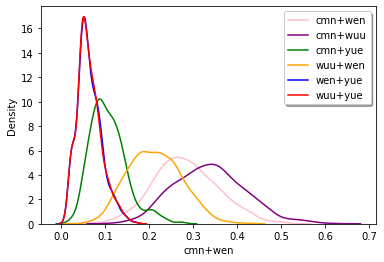

In [89]:
plot(df_cmn_wen, color="pink", annotate_mean=False)
plot(df_cmn_wuu, color= "purple",annotate_mean=False)
plot(df_cmn_yue, color="green", annotate_mean=False)
plot(df_wuu_wen, color= "orange",annotate_mean=False)
plot(df_wen_yue, color= "blue",annotate_mean=False)
plot(df_wuu_yue, color="red", annotate_mean=False)